# A/B TESTING

>*A/B Testing* atau juga dikenal sebagai *Split Testing* atau *Bucket Testing* merupakan metode yang digunakan sebagai metode yang membandingkan dua versi halaman web atau aplikasi untuk menentukan web atau aplikasi mana yang berkinerja lebih baik. *A/B Testing* pada dasarnya adalah percobaan di mana dua atau lebih varian halaman ditampilkan kepada pengguna secara acak, dan analisis statistik digunakan untuk menentukan variasi mana yang berkinerja lebih baik untuk sasaran konversi yang diberikan.
<br>

>**Proses *A/B Testing Analysis*** <br>
Berikut ini adalah kerangka kerja pengujian A / B yang dapat Anda gunakan untuk mulai menjalankan tes:
<br>
1. *Kumpulkan Data* <br>
2. *Identifikasi Sasaran* <br>
3. *Hasilkan Hipotesis* <br>
4. *Buat Variasi* <br>
5. *Jalankan Eksperimen* 
6. *Menganalisis Hasil* <br>
![Capture](AB.jpg)
<br>
<br>
Data yang akan digunakan dalam mengaplikasikan *A/B Testing* merupakan data e-commerce dimana terdapat dua kelompok pengguna, diantaranya yaitu *"Control Group"* dan *"Treatement Group"*. Kedua kelompok masing-masing dihadapkan pada tampilan web yang berbeda. Pada pengguna *Control Group* dihadapkan pada *old page* (tampilan web lama), sedangkan pada pengguna *Treatement Group* dihadapkan pada  *new page* (tampilan web baru). Untuk lebih jelasnya, dapat dilihat berdasarkan skema data yang akan digunakan sebagai berikut.
![Capture](AB1.jpg)

## Tujuan 
>*A/B Testing* yang akan dilakukan yaitu bertujuan untuk membantu perusahaan memahami apakah perusahaan harus mengimplementasikan *website* dengan menggunakan tampilan yang baru, mempertahankan tampilan web yang lama, atau mungkin menjalankan eksperimen lebih lama untuk membuat keputusan. 
<br>

## Outline
<ul>
<li><a href="#install">Install Package</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#probability">Probabilitas</a></li>
<li><a href="#abtesting">AnalisisAB Testing </a></li>
<li><a href="#Kesimpulan"> Kesimpulan</a></li>
</ul>
***

<a id='install'></a>
## 1. Install Package

In [8]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from scipy.stats import norm
from IPython.display import Image

<a id='wrangling'></a>
## 2. Data Wrangling
> Sebelum melakukan analisis lebih lanjut, maka perlu dilakukan wrangling data guna memahami data yang akan digunakan.

In [9]:
# Load Data & Memunculkan 5 Data Teratas 
df=pd.read_csv('D:/Python/Machine Learning/5. Association/Marketing Analytics/data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
df['user_id'].nunique()

290584

In [11]:
df.converted.mean()

0.11965919355605512

In [12]:
df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == False].count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [14]:
# Melakukan pengecekan pada proporsi pengguna yang converted
p= df.query('converted == 1').user_id.nunique()/df.shape[0]
print("Proporsi pengguna converted adalah {0:.2%}".format(p))

Proporsi pengguna converted adalah 11.94%


In [15]:
# Periksa berapa kali halaman dan pengobatan yang baru tidak sejajar.
l = df.query('(group == "treatment" and landing_page != "new_page" ) \
         or (group != "treatment" and landing_page == "new_page")').count()[0]
print("Jumlah new_page & treatement yang tidak sesuai adalah {}".format(l))

Jumlah new_page & treatement yang tidak sesuai adalah 3893


In [16]:
# Melakukan pengecekan Missing Values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

> Untuk baris di mana **treatment** tidak selaras dengan **new_page** atau **kontrol** tidak selaras dengan **old_page**, maka tidak dapat memastikan apakah baris ini benar-benar menerima halaman baru atau lama. Jadi, disini akan melakukan drop baris-baris tersebut dan membuat kerangka data baru.

In [17]:
df2 = df.drop(df.query('(group == "treatment" and landing_page != "new_page" ) \
                      or (group != "treatment" and landing_page == "new_page") or (group == "control" and landing_page != "old_page") or (group != "control" and landing_page == "old_page")').index)

In [18]:
# Melakukan pengecekan ulang apakah benar-benar baris yang tidak sesuai telah dihapus 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [19]:
# Melakukan pengecekan unique user_ids pada df2
df2.user_id.nunique()

290584

In [20]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


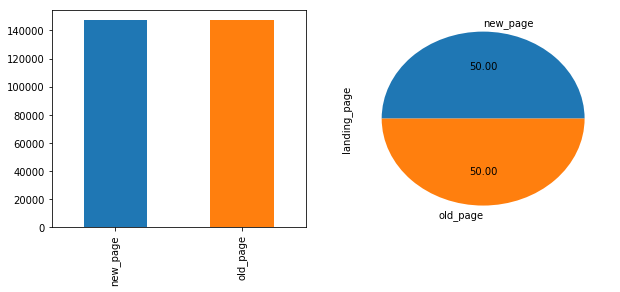

In [71]:
# Proporsi item landing_page pada data
f=plt.figure(figsize=(10,4))
f.add_subplot(1,2,1)
df['landing_page'].value_counts().plot(kind='bar');
f.add_subplot(1,2,2)
df['landing_page'].value_counts().plot(kind='pie', autopct='%.2f');

In [22]:
# Melakukan pengecekan pada baris yang terduplikat
df2.user_id.duplicated().sum()

1

In [23]:
# Melakukan pengecekan pada user_id yang berulang
df2[df2.duplicated(['user_id'],keep=False)]['user_id']
print("User ID yang terulang adalah user_id 773192")

User ID yang terulang adalah user_id 773192


In [24]:
# Melakukan pengecekan informasi baris untuk user_id yang berulang
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [25]:
# Menghapus salah satu baris yang berulang
df2 = df2.drop(df2.query('user_id == 773192 and timestamp == "2017-01-09 05:37:58.781806"').index)

In [26]:
# Melakukan pengecekan kembali pada user_id yang berulang
df2.user_id.duplicated().sum()

0

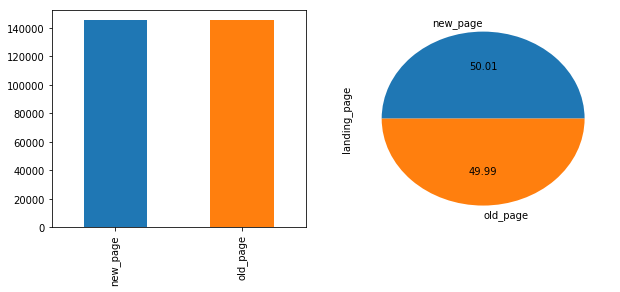

In [72]:
# Proporsi item landing_page pada data yang telah siap diolah
f=plt.figure(figsize=(10,4))
f.add_subplot(1,2,1)
df2['landing_page'].value_counts().plot(kind='bar');
f.add_subplot(1,2,2)
df2['landing_page'].value_counts().plot(kind='pie', autopct='%.2f');

<a id='probability'></a>
## 3. Probabilitas

> Sebelum melakukan *AB Testing*, untuk mengetahui pengguna pada *Control Group* ataupun pada *Treatement Group* apakah sudah memilih tampilan web yang sesuai dengan tampilan awal ataupun berpaling dari tampilan web yang dihadapkan dapat dilihat berdasarkan probabilitas dari masing-masing karakteristik yang diinginkan.

In [27]:
# Menghitung probabilitas setiap pengguna dengan converted = 1 
df_prob =df2.query('converted == 1').user_id.nunique()/df2.user_id.nunique()
df_prob

print("Probabilitas seseorang yang tidak memilih halaman berdasarkan halaman yang diterima (converted) adalah {0:.2%}".format(df_prob))

Probabilitas seseorang yang tidak memilih halaman berdasarkan halaman yang diterima (converted) adalah 11.96%


In [28]:
# Menghitung probabilitas pengguna yang berada dalam control group dan terconvert
p_cont = df2.query('converted == 1 and group == "control"').user_id.nunique() \
/df2.query('group == "control"').user_id.nunique()

print("Probabilitas pengguna yang berada dalam control group dan terconvert adalah {0:.2%}".format(p_cont))

Probabilitas pengguna yang berada dalam control group dan terconvert adalah 12.04%


In [29]:
# Menghitung probabilitas pengguna yang berada dalam treatement group dan terconvert
p_treat = df2.query('converted == 1 and group == "treatment"').user_id.nunique() \
/df2.query('group == "treatment"').user_id.nunique()

print("Probabilitas pengguna yang berada dalam treatement group dan terconvert adalah {0:.2%}".format(p_treat))

Probabilitas pengguna yang berada dalam treatement group dan terconvert adalah 11.88%


In [30]:
# Menghitung probabilitas pada saat setiap individu mendapatkan halaman baru (new page)
p_n = df2.query('landing_page == "new_page"').user_id.nunique()/df2.user_id.nunique()

print("Probabilitas setiap individu mendapatkan halaman baru (new page) {0:.2%}".format(p_n))

Probabilitas setiap individu mendapatkan halaman baru (new page) 50.01%


> Berdasarkan hasil probabilitas, maka dapat diketahui bahwa tidak tidak ada cukup bukti untuk mengatakan bahwa pengguna pada group *new treatement* lebih banyak yang terconvert dibandingkan dengan pengguna pada group *page control*. Probabilitas pengguna yang berada dalam control group dan terconvert adalah 12,04% sedangkan pada kelompok *treatement* adalah 11,88%. Jika dilihat selisih dari kedua probabilitas tersebut maka dapat dikatakan sangat kecil, terutama pada saat membandingkannya dengan probabilitas seseorang yang tidak memilih halaman berdasarkan halaman yang diterima (11,96%)
>.

<a id='install'></a>
## 4. Analisis A/B Testing

> Dikarenakan pada saat melihat probabilitas pengguna yang terconvert pada treatement group dan control group tidak memiliki perbedaan yang signifikan. Dan menjadikan tidak adanya bukti yang kuat untuk mengatakan pengguna pada *treatement group* lebih banyak tetap menggunakan web dengan tampilan baru atau berpaling pada web dengan tampilan sebelumnya.Maka selanjutnya dapat dilakukan tes hipotesis menggunakan A/B Testing yang dimana memperhatikan pengamatan berdasarkan waktu yang terkait dengan setiap peristiwa.
<br>

>Pada bagian ini akan mempertimbangkan untuk membuat keputusan hanya berdasarkan semua data yang disediakan. Selanjutnya yaitu mengasumsikan bahwa web dengan tampilan *old page* lebih baik dibandingkan dengan web dengan tampilan *new page*. Uji hipotesis yang digunakan untuk mengetahui bahwa pernyataan tersebut terbukti benar-benar lebih baik pada tingkat kesalahan tipe I 5%. Hipotesis nol dan alternatif mengikuti dapat dijelasakn sebagai berikut:

**Hypothesis**
* $H_{0}$: $P_{new}$-$P_{old}$ $<=$ $0$
* $H_{1}$: $P_{old}$ - $P_{new}$ $>$ $0$



In [31]:
# Karena P_new dan P_old keduanya memiliki tingkat keberhasilan "benar" yang sama
p_new = df2.converted.mean()
print("Tingkat konversi untuk P_new di bawah nol adalah {0:.4}".format(p_new))

Tingkat konversi untuk P_new di bawah nol adalah 0.1196


In [32]:
p_old = df2.converted.mean()
print("Tingkat konversi untuk P_old di bawah nol adalah {0:.4}".format(p_old))

Tingkat konversi untuk P_old di bawah nol adalah 0.1196


In [33]:
# Menghitung total 'unique users' dengan halaman baru (new page)
n_new = df2.query('landing_page == "new_page" ').count()[0]
n_new

145310

In [34]:
# Menghitung total 'unique users' dengan halaman lama (old page)
n_old = df2.query('landing_page == "old_page" ').count()[0]
n_old

145274

In [35]:
# Simulasikan transaksi n_new dengan tingkat konversi p_new di bawah nol
new_page_converted = np.random.choice([0,1],n_new, p=(p_new,1-p_new))
new_page_converted

array([1, 1, 0, ..., 0, 1, 0])

In [36]:
# Simulasikan transaksi n_old dengan tingkat konversi p_old di bawah nol
# Simpan n_new 1 dan 0 ini di old_page_converted
old_page_converted = np.random.choice([0,1],n_old, p=(p_old,1-p_old))
old_page_converted

array([1, 0, 1, ..., 1, 1, 1])

>Menentukan perbedaan antara p_new dan p_old. Untuk menemukan perbedaan antara p_new dan p_old, perlu mencari tahu mean  dari new_page_converted dan old_page_converted.

In [37]:
new_page_converted.mean()

0.8804762232468516

In [38]:
old_page_converted.mean()

0.8802125638448725

>Untuk mengetahui perbedaan antara p_new dan p_old dapat menyelisihkan kedua nilai tersebut

In [39]:
diff_conv = new_page_converted.mean() - old_page_converted.mean()
diff_conv

0.00026365940197914384

>Mensimulasikan 10.000 p_new - nilai p_old dengan binomial acak

In [40]:
new_converted_simulation = np.random.binomial(n_new, p_new,  10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old,  10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

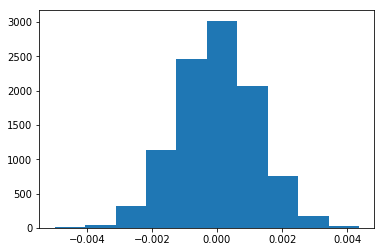

In [41]:
p_diffs = np.array(p_diffs)
plt.hist(p_diffs);

> Menghitung perbedaan nilai aktual yang diamati

In [42]:
new_convert = df2.query('converted == 1 and landing_page == "new_page"').count()[0]/n_new
old_convert = df2.query('converted == 1 and landing_page == "old_page"').count()[0]/n_old
obs_diff = new_convert - old_convert
obs_diff

-0.0015782389853555567

In [43]:
# Check the proportion of the p_diffs are greater than the actual difference observed in ab_data.
# Periksa proporsi p_diffs lebih besar dari perbedaan aktual yang diamati pada ab_data.
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

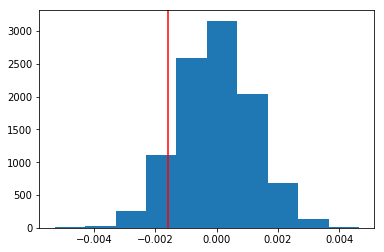

In [44]:
plt.hist(null_vals);
plt.axvline(x=obs_diff, color='red')

In [45]:
(null_vals > obs_diff).mean()

0.9076

> Sampling distribution analysis :
- Proporsi perbedaan tingkat konversi lebih besar daripada perbedaan yang diamati sebenarnya. Nilai p sangat besar (90%) dari pada tingkat kesalahan tipe I (5%). Itu berarti keputusan "Gagal Tolak H0".
- Ketika nilai-p rendah (dalam analisis kali ini kurang dari 5%), hal tersebut menunjukkan bahwa hipotesis Gagal Tolak H0, sehingga perlu mempertimbangkan hipotesis alternatif. Akhirnya, nilai p 90% menunjukkan bahwa halaman sebenarnya harus dipertahankan.

In [46]:
convert_old = df2.query('converted == 1 and landing_page == "old_page"').count()[0]
convert_new = df2.query('converted == 1 and landing_page == "new_page"').count()[0]
n_old = df2.query('landing_page == "old_page" ').count()[0]
n_new = df2.query('landing_page == "new_page" ').count()[0]

In [47]:
convert_old,convert_new,n_old,n_new

(17489, 17264, 145274, 145310)

In [48]:
z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),\
                                              np.array([n_new,n_old]), alternative = 'larger')

In [49]:
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [52]:
norm.cdf(z_score)

0.09494168724097551

In [53]:
norm.ppf(1-(0.05/2))

1.959963984540054

In [68]:
def Z_test(convert_new,convert_old):
    z_score, p_value = sm.stats.proportions_ztest(np.array([convert_new,convert_old]),\
                                              np.array([n_new,n_old]), alternative = 'larger')
    ztabel=norm.ppf(1-(0.05/2))
    Keputusan1='Tolak H0'
    Keputusan2='Gagal Tolak H0'
    Keputusan= Keputusan1 if p_value<0.05 else Keputusan2
    
    tabel=pd.DataFrame()
    tabel['Z_Score']=[z_score]
    tabel['P-Value']=[p_value]
    tabel['Z-Tabel']=[ztabel]
    tabel['Keputusan']=[Keputusan]
    return tabel

In [69]:
Z_test(convert_new,convert_old)

,Z_Score,P-Value,Z-Tabel,Keputusan
0,-1.310924,0.905058,1.959964,Gagal Tolak H0


## 5. Kesimpulan

> Berdasarkan uji statistika menggunakan A/B Testing menunjukkan z-score (z-hitung) sebesar 1,31 sedangkan nilai z-tabel sebesar 1,96, maka dapat diketahui bahwa nilai z-hitung (1,31) < z-tabel (1,96) sehingga keputusan yang diperoleh yaitu Gagal Tolak H0. Maka dapat disimpulkan bahwa tingkat converted *old page* atau web dengan tampilan lama lebih besar atau sama dengan tingkat konversi halaman baru. Selain itu, tidak ada perbedaan yang signifikan antara tingkat konversi halaman baru dan tingkat konversi halaman lama (> 0,15%).

Referensi : 
> https://www.optimizely.com/optimization-glossary/ab-testing/#targetText=AB%20testing%20is%20essentially%20an,for%20a%20given%20conversion%20goal